In [1]:
using CSV
using DataFrames
using Printf
using JSON
using Statistics
using LinearAlgebra
using JLD2
using PyPlot
using FileIO
include("recsys_funcs.jl")

loo_filename (generic function with 1 method)

## fake data

create a fake $H$ matrix that obeys a known factorization

In [2]:
n_m = 200
n_g = 150
r = 2
M = randn(r, n_m)
G = randn(r, n_g)
γ = randn(1, n_g)
μ = randn(1, n_m)
h̄ = 0.6

H_truth = M' * G .+ γ .+ μ' .+ h̄

200×150 Array{Float64,2}:
  0.387229   -1.27776    -0.0586096  …   1.4473     -0.4017     -2.59249 
 -0.716602   -2.2901     -0.503136       0.535576   -0.496701   -3.94208 
  0.409093   -1.79231    -0.0799361      1.34026    -0.563453   -3.92287 
  0.178162   -0.81951     1.80417        1.92521     2.64362    -2.59399 
  0.228694   -1.3587     -0.374401       1.26475    -0.778833   -2.43596 
 -1.61439    -0.762065    1.85149    …   1.01846     4.01968    -0.958496
 -2.53815    -1.10578     0.735127       0.171645    2.93565    -0.24518 
 -3.57269    -2.3372     -0.782962      -1.03225     1.13245    -1.43428 
 -1.84193    -2.55463     1.11235        0.31422     2.67826    -4.84951 
 -0.568529   -0.0328728   0.493419       1.36758     1.39092     1.02701 
 -1.68529    -1.25085     0.99916    …   0.652013    2.68451    -1.53642 
  1.32034    -0.313674    0.951167       2.40721     0.653226   -1.6355  
 -6.18055    -3.06873     0.586965      -2.19066     4.90462    -2.10833 
  ⋮         

mask missing values

In [3]:
idx_missing = [rand(1:4) for i = 1:n_m, j = 1:n_g] .== 1
H = deepcopy(H_truth)
H = convert(Array{Union{Float64, Missing}}, H)
# H = copy(H_truth)
# [missing for i = 1:n_m, j = 1:n_g]
H[idx_missing] .= missing
H

200×150 Array{Union{Missing, Float64},2}:
   missing  -1.27776    -0.0586096  …   1.4473     -0.4017       missing
 -0.716602  -2.2901     -0.503136       0.535576   -0.496701   -3.94208 
  0.409093  -1.79231    -0.0799361      1.34026    -0.563453   -3.92287 
  0.178162  -0.81951     1.80417         missing    2.64362      missing
  0.228694  -1.3587     -0.374401       1.26475    -0.778833   -2.43596 
 -1.61439     missing    1.85149    …   1.01846     4.01968    -0.958496
 -2.53815     missing    0.735127        missing    2.93565    -0.24518 
   missing  -2.3372       missing      -1.03225     1.13245    -1.43428 
 -1.84193     missing    1.11235        0.31422     2.67826      missing
 -0.568529  -0.0328728    missing       1.36758      missing    1.02701 
 -1.68529   -1.25085     0.99916    …    missing    2.68451    -1.53642 
  1.32034   -0.313674     missing       2.40721     0.653226   -1.6355  
 -6.18055     missing    0.586965      -2.19066     4.90462    -2.10833 
  ⋮      

In [4]:
λ₁ = 1000.0
λ₂ = 1000.0

M_p, G_p, μ_p, γ_p, h̄_p, train_rmses, losses = ALS(H, r, [λ₁, λ₂], 
    min_als_sweeps=50, verbose=true, max_als_sweeps=100)

H_predicted = M_p' * G_p .+ h̄_p .+ μ_p' .+ γ_p

M shape: (2, 200)	G shape: (2, 150)
ALS sweep 10
	training loss = 2653.239868095138
	training RMSE = 0.0872460430581392
ALS sweep 20
	training loss = 2621.4498529489483
	training RMSE = 0.08692243371586647
ALS sweep 30
	training loss = 2613.057277026051
	training RMSE = 0.08698832196103291
ALS sweep 40
	training loss = 2610.6865678417475
	training RMSE = 0.08690875782778223
ALS sweep 50
	training loss = 2610.0447221670156
	training RMSE = 0.08693147999478523
ALS sweep 60
	training loss = 2609.846555568697
	training RMSE = 0.08693585566455206
loss stopped decreasing


200×150 Array{Float64,2}:
  0.3934     -1.19784    -0.0431773  …   1.41387   -0.379749  -2.42518 
 -0.662765   -2.16487    -0.4638         0.540082  -0.462352  -3.718   
  0.425087   -1.70124    -0.0648527      1.3135    -0.548752  -3.72938 
  0.191497   -0.745859    1.74755        1.86661    2.55519   -2.40699 
  0.244438   -1.28126    -0.336881       1.24237   -0.731081  -2.29964 
 -1.52394    -0.696307    1.78789    …   0.991061   3.87174   -0.873623
 -2.41045    -1.02942     0.727118       0.18241    2.84856   -0.210411
 -3.37263    -2.20583    -0.718164      -0.950812   1.11332   -1.36909 
 -1.75265    -2.4112      1.07377        0.309272   2.57976   -4.5656  
 -0.513735   -0.0125578   0.493818       1.33932    1.35139    0.986225
 -1.60029    -1.17128     0.968883   …   0.636447   2.59137   -1.43009 
  1.29247    -0.270921    0.925604       2.33695    0.630186  -1.50562 
 -5.91212    -2.89865     0.587721      -2.09757    4.75913   -1.9811  
  ⋮                                  ⋱

In [2]:
function mk_diagonal()
    lim = ax.get_ylim()
    ax.plot(lim, lim)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
end

mk_diagonal (generic function with 1 method)

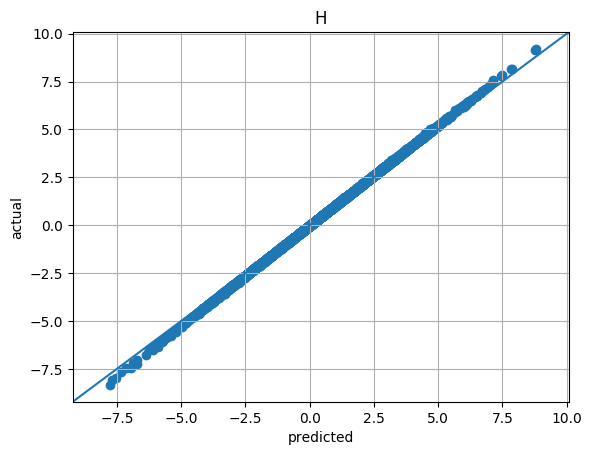

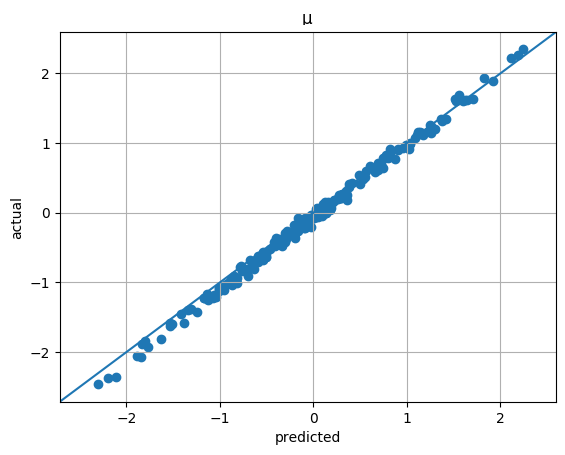

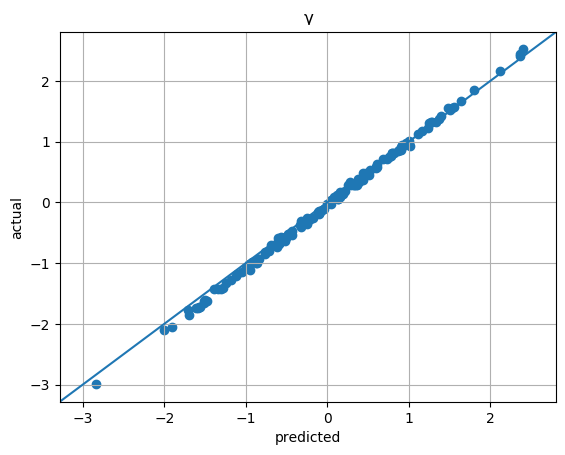

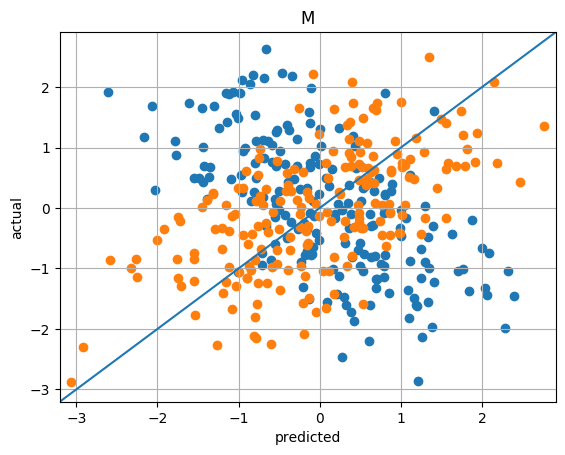

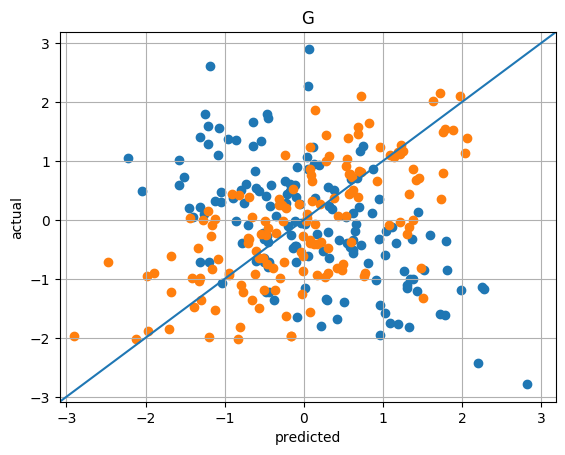

In [5]:
fig, ax = plt.subplots()
plt.scatter(H_predicted[idx_missing], H_truth[idx_missing])
plt.grid()
xlabel("predicted")
ylabel("actual")
mk_diagonal()
ax.set_title("H")
plt.show(fig)

    
fig, ax = plt.subplots()
plt.scatter(μ_p, μ)
xlabel("predicted")
ylabel("actual")
mk_diagonal()
plt.grid()
ax.set_title("μ")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(γ_p, γ)
xlabel("predicted")
ylabel("actual")
mk_diagonal()
plt.grid()
ax.set_title("γ")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(M_p[1, :], M[1, :])
plt.scatter(M_p[2, :], M[2, :])
xlabel("predicted")
mk_diagonal()
ylabel("actual")
plt.grid()
ax.set_title("M")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(G_p[1, :], G[1, :])
plt.scatter(G_p[2, :], G[2, :])
xlabel("predicted")
mk_diagonal()
ylabel("actual")
plt.grid()
ax.set_title("G")
plt.show(fig)

# real data

In [126]:
henry_df = CSV.read(joinpath("..", "data", "henry_matrix_df_l_4.csv"))
H = convert(Array{Union{Float64, Missing}, 2}, henry_df[1:end, 2:end])
log_H = log10.(H);
log_H

208×40 Array{Union{Missing, Float64},2}:
 -0.117023   -0.838919   -0.495657     missing  …   missing  missing  missing
  1.95263    -0.267928   -0.0489059  -0.925784     2.24926   missing  missing
  0.363108   -0.484648   -0.29561    -0.68491       missing  missing  missing
  0.176075   -0.647117   -0.118948   -0.737644      missing  missing  missing
  0.713802   -0.495113   -0.050361   -0.480904      missing  missing  missing
 -0.682291     missing     missing     missing  …   missing  missing  missing
  0.731612     missing    0.18501      missing      missing  missing  missing
  0.22006    -0.662683   -0.362097     missing      missing  missing  missing
   missing     missing    2.11721      missing      missing  missing  missing
  0.783864    0.117892    0.424465     missing      missing  missing  missing
  0.779426    0.0311591   0.158529     missing  …   missing  missing  missing
  0.739098    0.0290573   0.344262     missing      missing  missing  missing
  0.562251   -0.157806 

In [127]:
# standardize the columns
for j = 1:size(log_H)[2]
    # find ids that are not missing
    ids = .! ismissing.(log_H[:, j])
    # Hij <-- (Hij - μ_j) / σ_j 
    log_H[:, j] .= (log_H[:, j] .- mean(log_H[ids, j])) ./ std(log_H[ids, j])
end

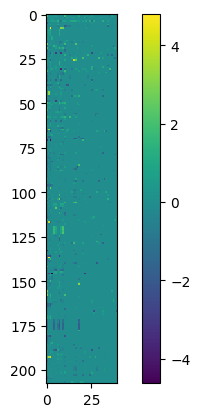

PyObject <matplotlib.colorbar.Colorbar object at 0x7f2073b390f0>

In [128]:
spy_log_H = deepcopy(log_H)
spy_log_H[ismissing.(log_H)] .= 0.0

figure()
imshow(spy_log_H)
colorbar()

In [129]:
using LowRankModels
using Statistics

ids_obs = observations(log_H) # returns tuple of observations
nb_obs = length(observations(log_H))
println("# observations = ", nb_obs)

r = QuadReg(0.01)
k = 2

glrm = GLRM(log_H, QuadLoss(), r, r, k, obs=observations(log_H))

X, Y, ch = fit!(glrm)

# observations = 1176
Fitting GLRM
Iteration 10: objective value = 333.1681138110077
Iteration 20: objective value = 316.3233560138788
Iteration 30: objective value = 310.5826700857735
Iteration 40: objective value = 303.5878761172883
Iteration 50: objective value = 299.4914516976142
Iteration 60: objective value = 297.46175062857213
Iteration 70: objective value = 296.31892283289665
Iteration 80: objective value = 295.62033178154627
Iteration 90: objective value = 295.1732406629213


([0.7151410849466888 -0.6147215891341047 … 0.43395556929242607 0.023870149929488334; 0.5311918683118688 -0.43178026775975625 … -0.7501463762205952 -0.16969527606876045], [-0.9290413727915569 -0.7518308125112363 … -0.693850265886294 -3.9000150608926156; -0.011186262913113669 -0.5110033888729945 … 0.21357413314312418 1.295256814495312], ConvergenceHistory("ProxGradGLRM", [2320.1913278545335, 912.9160022717043, 577.3108608533955, 448.6077735643563, 412.2967490419923, 394.66194441972874, 384.28888409113085, 376.003353332047, 365.7878321943777, 349.05665818947216  …  295.33018140641633, 295.28704404995733, 295.2450559026178, 295.2084725301436, 295.1732406629213, 295.1381831953347, 295.09800796938214, 295.06358606107, 295.03064184338075, 295.00135719292746], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.00187897

In [130]:
impute(glrm) # X' * Y

208×40 Array{Number,2}:
 -0.670338   -0.809106    -0.62284     …   -0.521417  -0.382752   -2.10103  
  0.575932    0.682808     0.540619         0.371027   0.334308    1.83816  
  0.0289656   0.0877997    0.00339739       0.351807  -0.0068224  -0.0505017
  0.0521834   0.077299     0.0421157        0.129787   0.0234676   0.125285 
  0.291927    0.443057     0.230876         0.792289   0.126585    0.672455 
 -0.628033   -1.00213     -0.474903    …   -2.00958   -0.25068    -1.31576  
  0.718786    0.463571     0.847665        -1.95864    0.589042    3.33321  
 -0.347917   -0.414321    -0.325765        -0.235608  -0.201139   -1.1055   
  3.12385     0.577559     4.32355        -17.4681     3.19538    18.329    
  1.06771     0.745786     1.2337          -2.55306    0.849699    4.79835  
  0.743362    0.657694     0.797304    …   -0.914632   0.530361    2.97047  
  1.007       0.695085     1.16724         -2.4596     0.805055    4.54771  
  0.58577     0.464661     0.652133        -1.05477 

In [131]:
r = QuadReg(1.0)
k = 1

glrm = GLRM(log_H, QuadLoss(), r, r, k, obs=observations(log_H))

params = Params(1.0, max_iter=150, abs_tol=0.00001, min_stepsize=0.01)

train_error, test_error, train_time, reg_params =
    regularization_path(glrm, params=params, reg_params=exp10.(range(2,stop=-2,length=15)), 
    holdout_proportion=0.35)

flattening observations
splitting train and test sets
forming train and test GLRMs
training model on 734 samples and testing on 442
params = ProxGradParams(1.0, 150, 1, 1, 1.0e-5, 0.0001, 0.01)
fitting train GLRM for reg_param 100.0
Fitting GLRM
Iteration 10: objective value = 759.145788972584
computing mean train and test error for reg_param 100.0:
	train error: 1.0342585680644725
	test error:  0.8526113371958248
fitting train GLRM for reg_param 51.7947467923121
Fitting GLRM
Iteration 10: objective value = 759.1457889594304
computing mean train and test error for reg_param 51.7947467923121:
	train error: 1.0342585680646201
	test error:  0.8526113371958588
fitting train GLRM for reg_param 26.826957952797258
Fitting GLRM
Iteration 10: objective value = 759.1457889594304
computing mean train and test error for reg_param 26.826957952797258:
	train error: 1.0342585680646201
	test error:  0.8526113371958588
fitting train GLRM for reg_param 13.894954943731374
Fitting GLRM
Iteration 10: objec

([1.0342585680644725, 1.0342585680646201, 1.0342585680646201, 1.0342585680646201, 1.0342585680646201, 1.0342585680646201, 1.0342585680646201, 1.0342585680646197, 1.0342585651002145, 0.4472860170003889, 0.43530274380248546, 0.4327218402186822, 0.4260144167152654, 0.4244202457783241, 0.42323913479931413], [0.8526113371958248, 0.8526113371958588, 0.8526113371958588, 0.8526113371958588, 0.8526113371958588, 0.8526113371958588, 0.8526113371958588, 0.8526113371958588, 0.8526113369080434, 0.8238116815210705, 0.8709787491514421, 0.9095231315138309, 1.029516481958395, 1.1217969023597916, 1.2282659500826683], [0.028818368911743164, 0.0590517520904541, 0.09833168983459473, 0.1214139461517334, 0.15131616592407227, 0.17467522621154785, 0.21105742454528809, 0.23366022109985352, 0.2613396644592285, 0.2830698490142822, 0.3069326877593994, 0.3302323818206787, 0.3963334560394287, 0.4255244731903076, 0.45101380348205566], [100.0, 51.7947467923121, 26.826957952797258, 13.894954943731374, 7.196856730011519,

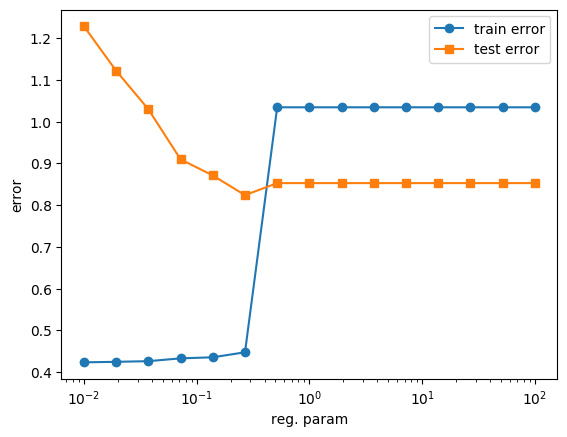

PyObject <matplotlib.legend.Legend object at 0x7f2073b70630>

In [132]:
figure()
plot(reg_params, train_error, marker="o", label="train error")
plot(reg_params, test_error, marker="s", label="test error")
xlabel("reg. param")
ylabel("error")
xscale("log")
legend()

In [157]:
params = Params(1.0, max_iter=100, abs_tol=0.0, min_stepsize=0.01)
train_error, test_error, train_glrms, test_glrms = cross_validate(glrm, nfolds=5, params=params, 
    error_fn=error_metric)

flattening observations
computing CV folds

forming train and test GLRM for fold 1
training model on 932 samples and testing on 244
fitting train GLRM for fold 1
Fitting GLRM
Iteration 10: objective value = 207.10847724546105
Iteration 20: objective value = 203.02045389411424
Iteration 30: objective value = 200.77655057139324
Iteration 40: objective value = 199.98058808278594
Iteration 50: objective value = 199.43900254537755
Iteration 60: objective value = 198.9356576200833
Iteration 70: objective value = 198.49331857286487
Iteration 80: objective value = 198.14048167652777
computing train and test error for fold 1:
	train error: 0.1949712044486721
	test error:  1.764315976200142

forming train and test GLRM for fold 2
training model on 927 samples and testing on 249
fitting train GLRM for fold 2
Fitting GLRM
Iteration 10: objective value = 199.4698346060193
Iteration 20: objective value = 195.4873586543959
Iteration 30: objective value = 194.09941820504673
computing train and test er

([0.1949712044486721, 0.1912830507911644, 0.1901592416777396, 0.2299899358620902, 0.217993859367345], [1.764315976200142, 1.3289726764691854, 1.3436223846149848, 0.8336800723195933, 1.114777629078138], GLRM[GLRM(Union{Missing, Float64}[-0.8147201290268428 -0.3857061222795752 … missing missing; 2.26651286949558 0.29507948317976196 … missing missing; … ; -0.7112321301472864 0.11951281454067897 … missing missing; missing missing … missing missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDo

In [136]:
r = QuadReg(0.1)
k = 2

glrm = GLRM(log_H, QuadLoss(), r, r, k, obs=observations(log_H))

X, Y, ch = fit!(glrm)

Fitting GLRM
Iteration 10: objective value = 339.1647049831621
Iteration 20: objective value = 317.1324096927422
Iteration 30: objective value = 315.9526949079936


([-0.9983042902693475 0.7205812838883745 … -0.501276469531178 0.27753430854869; 0.5809913126132682 -0.14844207181962724 … 0.23572416270322463 -0.016391579777608568], [1.4860610352022472 0.5605223669972574 … -0.4636858136168606 -0.8120715297332382; 0.3512990623464972 1.3125243415681007 … 1.959479089733365 0.16075105067134174], ConvergenceHistory("ProxGradGLRM", [3669.0638082037467, 1160.3333195110902, 854.1383933636452, 607.3369176773888, 454.1209197615907, 405.7068079295159, 383.2259044577735, 367.03994137148914, 354.46488816251764, 345.91280088282406  …  316.4549230610749, 316.3335609044399, 316.2425278796907, 316.1606417426231, 316.09741631293605, 316.0567333929592, 316.0004512579923, 315.9526949079936, 315.9112571880643, 315.890673155386], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.002187967300415039

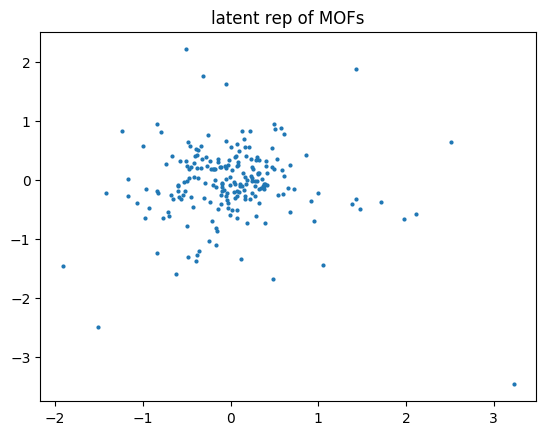

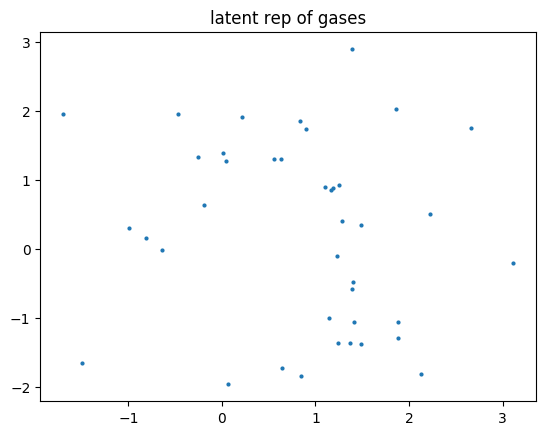

PyObject Text(0.5, 1, 'latent rep of gases')

In [147]:
figure()
scatter(X[1, :], X[2, :], s=4)
title("latent rep of MOFs")

figure()
scatter(Y[1, :], Y[2, :], s=4)
title("latent rep of gases")

In [137]:
actual_values = [log_H[i, j] for (i, j) in observations(log_H)]
log_H_complete = impute(glrm)
pred_values = [log_H_complete[i, j] for (i, j) in observations(log_H)]

1176-element Array{Float64,1}:
 -1.2794394036920096 
  1.0186802080395159 
  0.19527326869569442
  0.05241993641661469
  0.5185515747704984 
 -0.18158443356000709
  0.5484327078286423 
 -0.5414048338539952 
  0.6141600546882727 
  0.5007685797591562 
  0.4814167142784756 
  0.1990360022501119 
  0.4754243354281722 
  ⋮                  
 -0.41120615585456793
  0.5542629081480548 
  0.5043564434222916 
  0.8587395423464765 
 -0.7429377852279847 
 -0.702726803593487  
  0.45983731391398325
  0.6437202510952367 
 -0.15461929992159698
 -1.7113196308345384 
  0.517455874676112  
  0.4645698244575526 

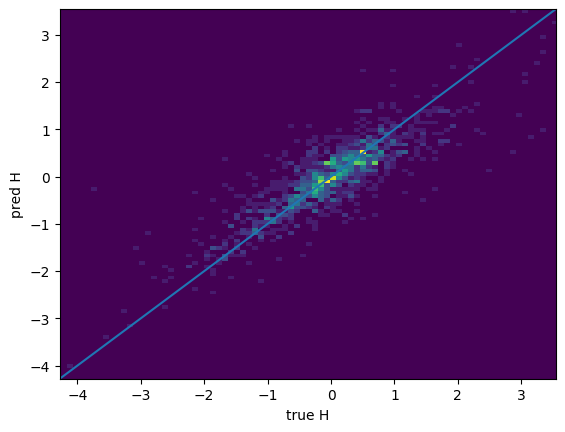

(-4.277969755785937, 3.5448723834007896)

In [148]:
# should at least fit the training data!
fig, ax = plt.subplots()
hist2D(actual_values, pred_values, bins=100)
xlabel("true H")
ylabel("pred H")
mk_diagonal()

In [35]:
test_error, log_H_pred = LOO_cross_validation(log_H, 2, 20.0, 28.0, "test_save_jld", 
    min_als_sweeps=5, max_als_sweeps=10, show_progress=true)

------------------------------
Starting LOO-ALS with the following parameters:
	r = 2, λ = [20.0000, 28.0000]


Progress:  60%|████████████████████████▋                |  ETA: 0:00:05

InterruptException: InterruptException:

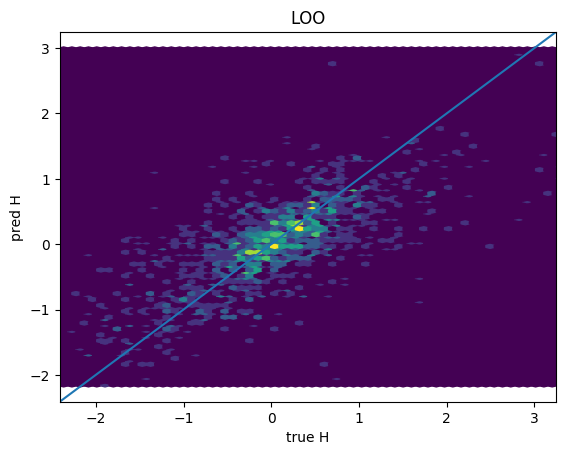

0.5041058804123223

In [41]:
# remove outliers

idx = (.! ismissing.(log_H)) .& (abs.(log_H_pred) .< 10.0)

fig, ax = plt.subplots()
hexbin(log_H[idx], log_H_pred[idx])
mk_diagonal()
xlabel("true H")
ylabel("pred H")
title("LOO")

SS_res = sum((log_H_pred[idx] .- log_H[idx]) .^ 2)
SS_tot = sum((log_H[idx] .- mean(log_H[idx])) .^ 2)

R2 = 1 - SS_res / SS_tot